In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    matthews_corrcoef, balanced_accuracy_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay)
from sklearn.utils import resample

import re
import shap

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("phik").setLevel(logging.ERROR)

# Modelado e Interpretación

In [66]:
df = pd.read_csv('../data/processed.csv')
features = df.columns.drop('Survived')
df.head()

,Age,Pclass_2,Pclass_3,Sex_male,CabinKnown,FareAboveMedian,Survived
0,22,0,1,1,0,0,0
1,38,0,0,0,1,1,1
2,26,0,1,0,0,0,1
3,35,0,0,0,1,1,1
4,35,0,1,1,0,0,0


In [67]:
Y = df["Survived"]
X = df.drop(columns=["Survived"])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## XGBoost

Hallamos los mejores hiperparámetros:

In [68]:
# learning_rate = [0.01, 0.05, 0.1, 0.3]
# n_estimators = [100, 200, 300]
# max_depth = [3, 5, 7]
# subsample = [0.7, 0.8, 0.9, 1.0]
# colsample_bytree = [0.7, 0.8, 0.9, 1.0]
# gamma = [0, 0.1, 0.3, 0.5]
# def hyperparametros(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma):
#     best_accuracy = 0
#     for lr in learning_rate:
#         for n in n_estimators:
#             for md in max_depth:
#                 for s in subsample:
#                     for cs in colsample_bytree:
#                         for g in gamma:
#                             model = XGBClassifier(
#                                 learning_rate=lr,
#                                 n_estimators=n,
#                                 max_depth=md,
#                                 subsample=s,
#                                 colsample_bytree=cs,
#                                 gamma=g)
#                             model.fit(X_train, Y_train)
#                             y_pred = model.predict(X_test)
#                             accuracy = accuracy_score(Y_test, y_pred)
#                             if accuracy > best_accuracy:
#                                 best_accuracy = accuracy
#                                 best_params = [lr, n, md, s, cs, g]
#     return best_accuracy, best_params

# print(hyperparametros(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma))

Entrenamiento:

Accuracy: 0.7988826815642458

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.65      0.73        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.80      0.80      0.79       179



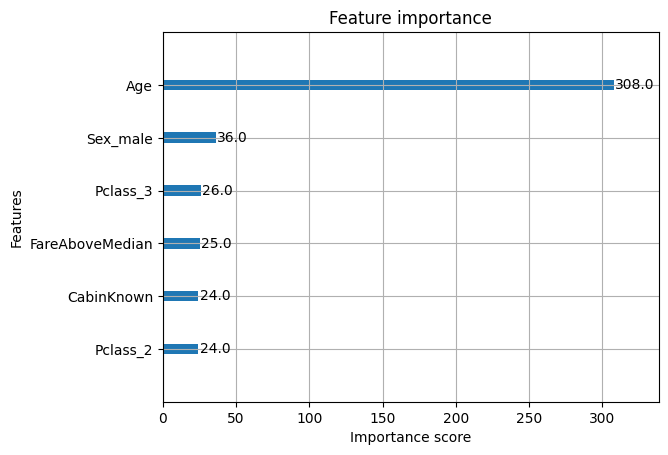

In [69]:
b_p = [0.3, 100, 5, 0.7, 0.7, 0.3]

model = XGBClassifier(
    n_estimators=b_p[1],
    learning_rate=b_p[0],
    max_depth=b_p[2],
    subsample=b_p[3],
    colsample_bytree=b_p[4],
    gamma=b_p[5],
    early_stopping_rounds=50,
    random_state=42)

model.fit(X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_test, Y_test)],
    verbose=False)
evals_result = model.evals_result()

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(Y_test, y_pred))

plot_importance(model)
plt.show()

Métricas de Evaluación:

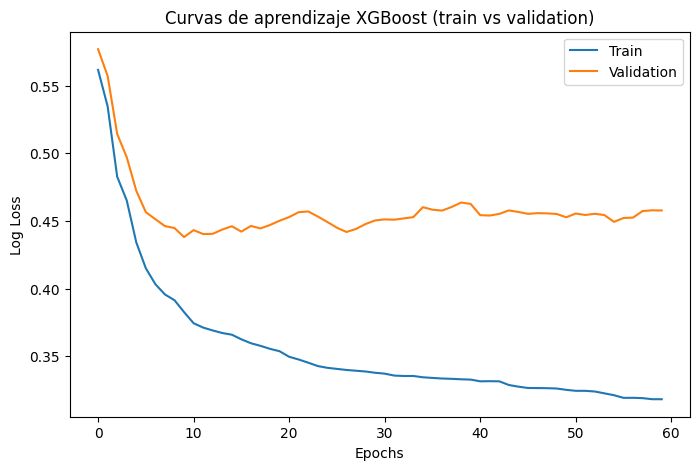

<Figure size 600x400 with 0 Axes>

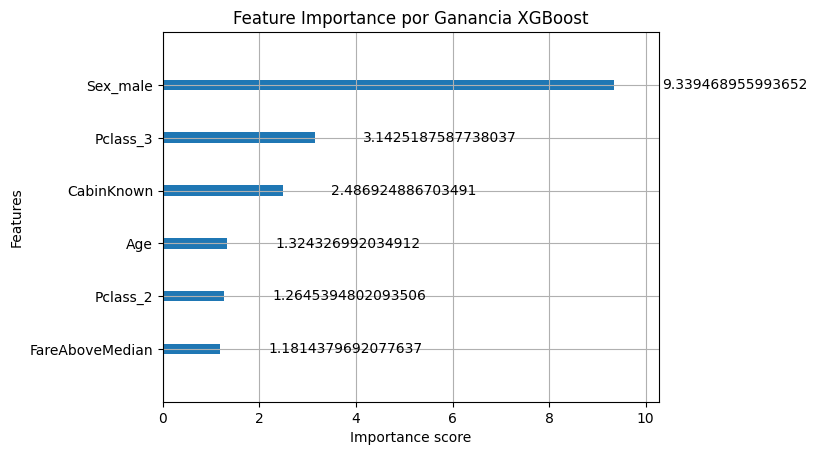

Best iteration: 9
Best score (logloss): 0.43804784243999245


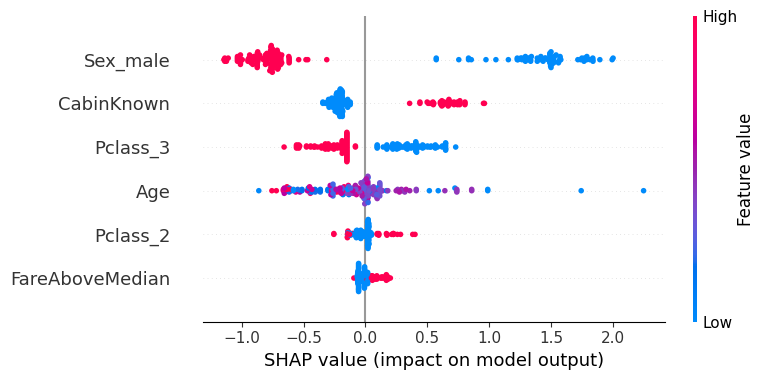

In [70]:
# 1. Curvas de aprendizaje
epochs = len(evals_result["validation_0"]["logloss"])
x_axis = range(0, epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, evals_result["validation_0"]["logloss"], label="Train")
plt.plot(x_axis, evals_result["validation_1"]["logloss"], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Curvas de aprendizaje XGBoost (train vs validation)")
plt.legend()
plt.show()

# 2. Importancia de variables por GANANCIA
plt.figure(figsize=(6, 4))
plot_importance(model, importance_type="gain")
plt.title("Feature Importance por Ganancia XGBoost")
plt.show()

# 3. Resultados con early stopping
print(f"Best iteration: {model.best_iteration}")
print(f"Best score (logloss): {model.best_score}")

# 4. Interpretación con SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

### Evaulación y Comparación

In [71]:
# Predicciones
y_proba = model.predict_proba(X_test)[:, 1] 

# Métricas básicas
accuracy  = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall    = recall_score(Y_test, y_pred)
f1        = f1_score(Y_test, y_pred)

roc_auc   = roc_auc_score(Y_test, y_proba)
pr_auc    = average_precision_score(Y_test, y_proba)
mcc       = matthews_corrcoef(Y_test, y_pred)
bal_acc   = balanced_accuracy_score(Y_test, y_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print(f"PR-AUC:    {pr_auc:.3f}")
print(f"MCC:       {mcc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")

Accuracy:  0.799
Precision: 0.828
Recall:    0.649
F1-Score:  0.727
ROC-AUC:   0.866
PR-AUC:    0.846
MCC:       0.582
Balanced Accuracy: 0.777


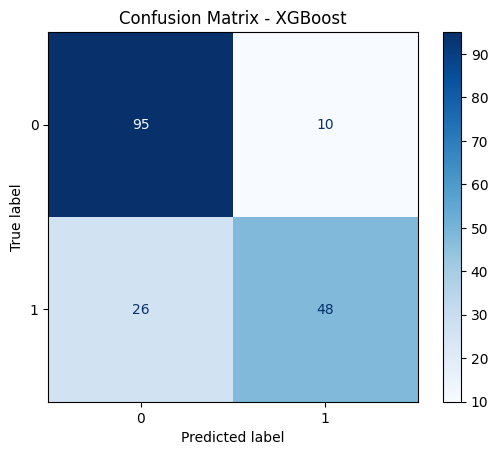

In [72]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

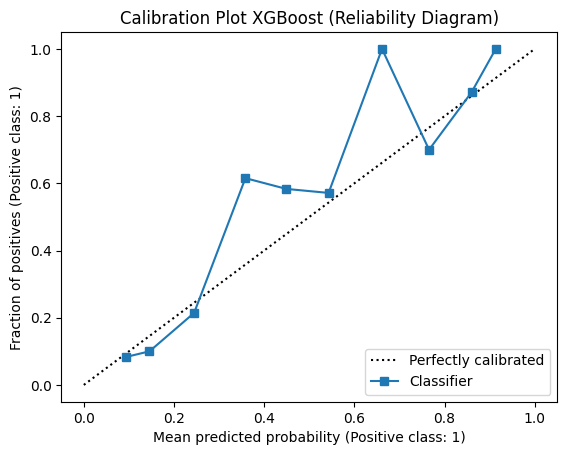

Brier Score: 0.13780890230956572
Expected Calibration Error (ECE): 0.06435644160435852


In [73]:
disp = CalibrationDisplay.from_predictions(
    Y_test, y_proba, n_bins=10, strategy="uniform")
plt.title("Calibration Plot XGBoost (Reliability Diagram)")
plt.show()

from sklearn.metrics import brier_score_loss

brier = brier_score_loss(Y_test, y_proba)
print("Brier Score:", brier)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            avg_conf = y_prob[mask].mean()
            avg_acc  = y_true[mask].mean()
            ece += np.abs(avg_conf - avg_acc) * len(y_prob[mask]) / len(y_prob)
    return ece

ece = expected_calibration_error(Y_test.values, y_proba, n_bins=10)
print("Expected Calibration Error (ECE):", ece)

## Regresión Logística

Hallamos los mejores hiperparámetros:

In [74]:
C = [0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2', 'elasticnet']
solver = ['liblinear', 'saga'] #para l1
class_weight = [None, 'balanced']

def hyperparametros(C, penalty, solver, class_weight):
    best_accuracy = 0
    for c in C:
        for p in penalty:
            if p == 'l1':
                for s in solver:
                    for cw in class_weight:
                        try:
                            model = LogisticRegression(
                                C=c,
                                penalty=p,
                                solver=s,
                                class_weight=cw,
                                max_iter=1000,
                                random_state=42)
                            model.fit(X_train, Y_train)
                            y_pred = model.predict(X_test)
                            accuracy = accuracy_score(Y_test, y_pred)
                            #print(accuracy)
                            if accuracy > best_accuracy:
                                best_accuracy = accuracy
                                best_params = [c, p, s, cw]
                        except:
                            continue
            else:
                for cw in class_weight:
                    try:
                        model = LogisticRegression(
                            C=c,
                            penalty=p,
                            solver=s,
                            class_weight=cw,
                            max_iter=1000,
                            random_state=42)
                        model.fit(X_train, Y_train)
                        y_pred = model.predict(X_test)
                        accuracy = accuracy_score(Y_test, y_pred)
                        #print(accuracy)
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = [c, p, s, cw]
                    except:
                        continue
    return best_accuracy, best_params

print(hyperparametros(C, penalty, solver, class_weight))

(0.8156424581005587, [10, 'l1', 'liblinear', None])


In [75]:
b_p = [10, 'l1', 'liblinear', None]

model = LogisticRegression(
    C=b_p[0],
    penalty=b_p[1],
    solver=b_p[2],
    class_weight=b_p[3],
    random_state=42)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(Y_test, y_pred))

Accuracy: 0.8156424581005587

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



Coeficientes del modelo:

In [76]:
coef = pd.DataFrame({
    "Variable": features,
    "Coef": model.coef_[0],
    "Exp(Coef)": np.exp(model.coef_[0])  # Odds ratio
}).sort_values(by="Coef", ascending=False)

print(coef)

          Variable      Coef  Exp(Coef)
4       CabinKnown  1.079072   2.941949
0              Age -0.024374   0.975921
1         Pclass_2 -0.066449   0.935711
5  FareAboveMedian -0.108619   0.897072
2         Pclass_3 -1.322356   0.266507
3         Sex_male -2.566938   0.076770


El valor exp(coef) (odds ratio):
- \>1 → aumenta la probabilidad de sobrevivir.
- <1 → reduce la probabilidad de sobrevivir.
- ≈1 → casi no afecta.

Entonces las variables más importantes son 'CabinKnown', 'Pclass_3' y 'Sex_male'.

Curvas de regularización:

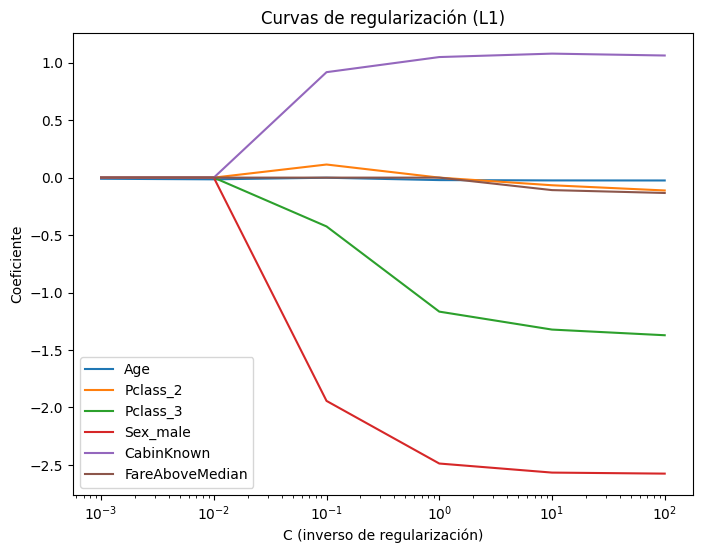

In [77]:
coefs = []
for c in C:
    model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000, C=c, class_weight=None, random_state=42)
    model.fit(X_train, Y_train)
    coefs.append(model.coef_[0])
    
coefs = np.array(coefs)

plt.figure(figsize=(8,6))
for i, feature in enumerate(features):
    plt.plot(C, coefs[:, i], label=feature)

plt.xscale("log")
plt.xlabel("C (inverso de regularización)")
plt.ylabel("Coeficiente")
plt.title("Curvas de regularización (L1)")
plt.legend()
plt.show()

Verificación de supuestos (linealidad en log-odds):

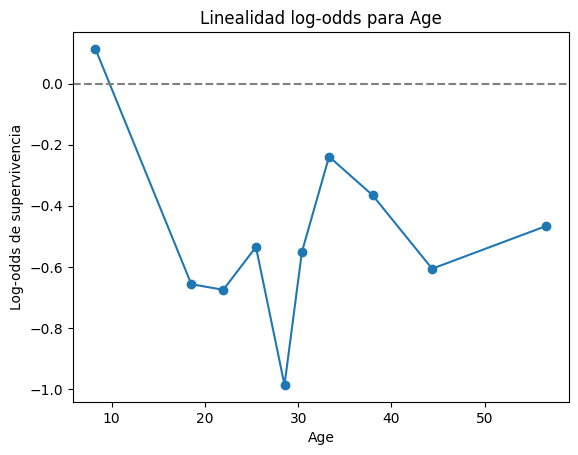

In [78]:
def check_linearity_logodds(df, feature, target, bins=10):
    df = df[[feature, target]].dropna()
    df['bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    
    grouped = df.groupby('bin').agg(
        mean_feature=(feature, 'mean'),
        mean_target=(target, 'mean')
    ).reset_index()
    
    grouped['log_odds'] = np.log(grouped['mean_target'] / (1 - grouped['mean_target']))
    
    plt.plot(grouped['mean_feature'], grouped['log_odds'], marker='o')
    plt.xlabel(feature)
    plt.ylabel("Log-odds de supervivencia")
    plt.title(f"Linealidad log-odds para {feature}")
    plt.axhline(0, color='gray', linestyle='--')
    plt.show()

check_linearity_logodds(df, "Age", "Survived")

### Evaulación y Comparación

In [79]:
# Predicciones
y_proba = model.predict_proba(X_test)[:, 1] 

# Métricas básicas
accuracy  = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall    = recall_score(Y_test, y_pred)
f1        = f1_score(Y_test, y_pred)

roc_auc   = roc_auc_score(Y_test, y_proba)
pr_auc    = average_precision_score(Y_test, y_proba)
mcc       = matthews_corrcoef(Y_test, y_pred)
bal_acc   = balanced_accuracy_score(Y_test, y_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print(f"PR-AUC:    {pr_auc:.3f}")
print(f"MCC:       {mcc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")

Accuracy:  0.816
Precision: 0.797
Recall:    0.743
F1-Score:  0.769
ROC-AUC:   0.871
PR-AUC:    0.859
MCC:       0.617
Balanced Accuracy: 0.805


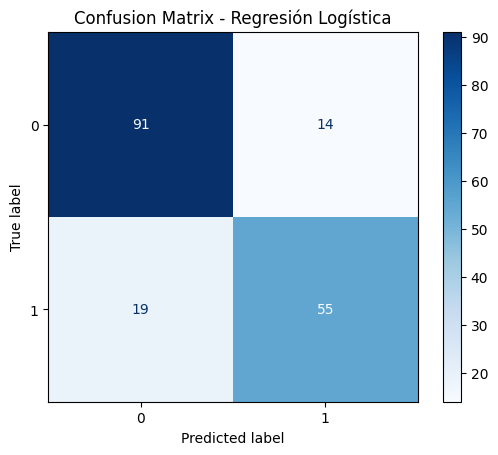

In [80]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Regresión Logística")
plt.show()

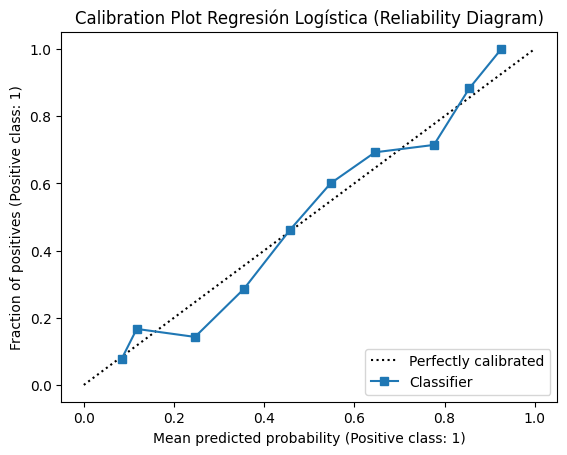

Brier Score: 0.13590075652970324
Expected Calibration Error (ECE): 0.044805202902366656


In [82]:
disp = CalibrationDisplay.from_predictions(
    Y_test, y_proba, n_bins=10, strategy="uniform")
plt.title("Calibration Plot Regresión Logística (Reliability Diagram)")
plt.show()

from sklearn.metrics import brier_score_loss

brier = brier_score_loss(Y_test, y_proba)
print("Brier Score:", brier)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            avg_conf = y_prob[mask].mean()
            avg_acc  = y_true[mask].mean()
            ece += np.abs(avg_conf - avg_acc) * len(y_prob[mask]) / len(y_prob)
    return ece

ece = expected_calibration_error(Y_test.values, y_proba, n_bins=10)
print("Expected Calibration Error (ECE):", ece)

## Random Forest

Hallamos los mejores hiperparámetros:

In [84]:
n_estimators = [100, 200, 300, 500]
max_depth = [3, 5, 7, 10, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['sqrt', 'log2', 0.3, 0.5]

# def hyperparametros(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
#     best_accuracy = 0
#     for n in n_estimators:
#         for md in max_depth:
#             for mss in min_samples_split:
#                 for msl in min_samples_leaf:
#                     for mf in max_features:
#                         try:
#                             model = RandomForestClassifier(
#                                 n_estimators=n,
#                                 max_depth=md,
#                                 min_samples_split=mss,
#                                 min_samples_leaf=msl,
#                                 max_features=mf,
#                                 random_state=42)
#                             model.fit(X_train, Y_train)
#                             y_pred = model.predict(X_test)
#                             accuracy = accuracy_score(Y_test, y_pred)
#                             if accuracy > best_accuracy:
#                                 best_accuracy = accuracy
#                                 best_params = [n, md, mss, msl, mf]
#                         except:
#                             continue
#     return best_accuracy, best_params
# hyperparametros(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)

(0.8435754189944135, [500, None, 5, 1, 0.5])

In [85]:
b_p = [500, None, 5, 1, 0.5]

model = RandomForestClassifier(
    n_estimators=b_p[0],
    max_depth=b_p[1],
    min_samples_split=b_p[2],
    min_samples_leaf=b_p[3],
    max_features=b_p[4],
    random_state=42)

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(Y_test, y_pred))

Accuracy: 0.8435754189944135

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       105
           1       0.86      0.74      0.80        74

    accuracy                           0.84       179
   macro avg       0.85      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



Feature importance (Gini y permutation)

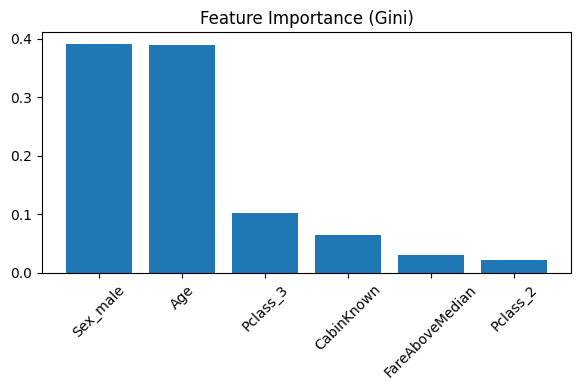

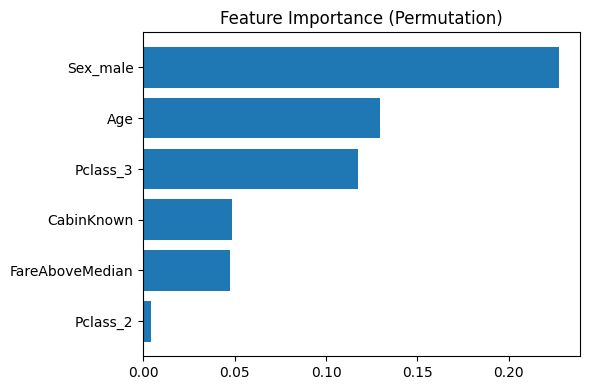

In [87]:
# Gini importance (impureza)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importance (Gini)")
plt.tight_layout()
plt.show()

# Permutation importance
perm_importance = permutation_importance(model, X_train, Y_train, n_repeats=30, random_state=42, n_jobs=-1)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(6,4))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.title("Feature Importance (Permutation)")
plt.tight_layout()
plt.show()

Análisis de profundidad efectiva de árboles

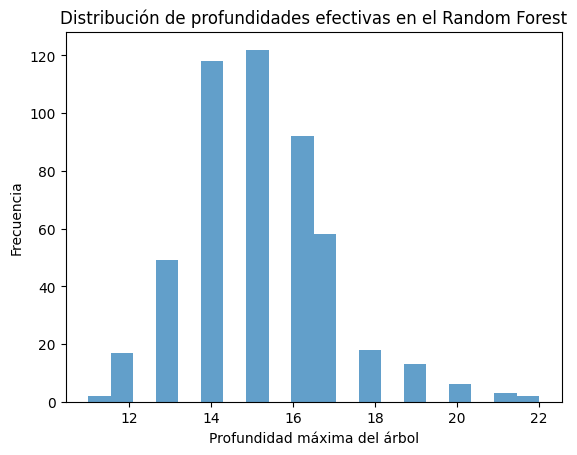

Profundidad media: 15.20, máx: 22, mín: 11


In [88]:
tree_depths = [estimator.tree_.max_depth for estimator in model.estimators_]

plt.hist(tree_depths, bins=20, alpha=0.7)
plt.xlabel("Profundidad máxima del árbol")
plt.ylabel("Frecuencia")
plt.title("Distribución de profundidades efectivas en el Random Forest")
plt.show()

print(f"Profundidad media: {np.mean(tree_depths):.2f}, máx: {np.max(tree_depths)}, mín: {np.min(tree_depths)}")

OOB score evolution

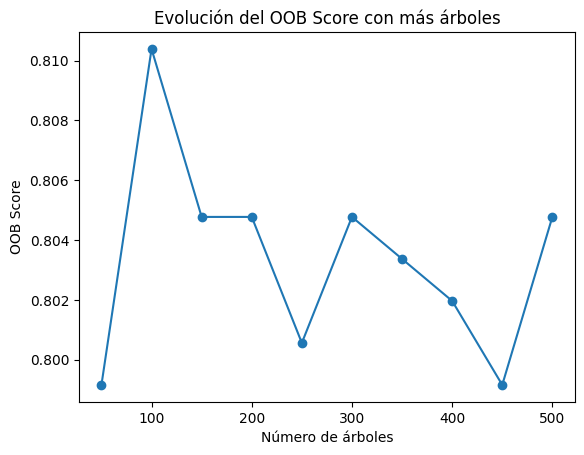

In [89]:
oob_scores = []
n_estimators_range = range(50, 501, 50)

for n in n_estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        max_depth=None,
        min_samples_split=b_p[2],
        min_samples_leaf=b_p[3],
        max_features=b_p[4],
        oob_score=True,
        random_state=42,
        n_jobs=-1)
    rf_temp.fit(X_train, Y_train)
    oob_scores.append(rf_temp.oob_score_)

plt.plot(n_estimators_range, oob_scores, marker="o")
plt.xlabel("Número de árboles")
plt.ylabel("OOB Score")
plt.title("Evolución del OOB Score con más árboles")
plt.show()

Estabilidad de importancias con diferentes seeds

                Age  Pclass_2  Pclass_3  Sex_male  CabinKnown  FareAboveMedian
seed 0     0.386785  0.021052  0.103551  0.395840    0.062692         0.030080
seed 42    0.389073  0.020895  0.104602  0.389399    0.065118         0.030913
seed 100   0.387276  0.024464  0.098662  0.392194    0.067077         0.030327
seed 2025  0.393914  0.022931  0.100575  0.391289    0.061175         0.030115


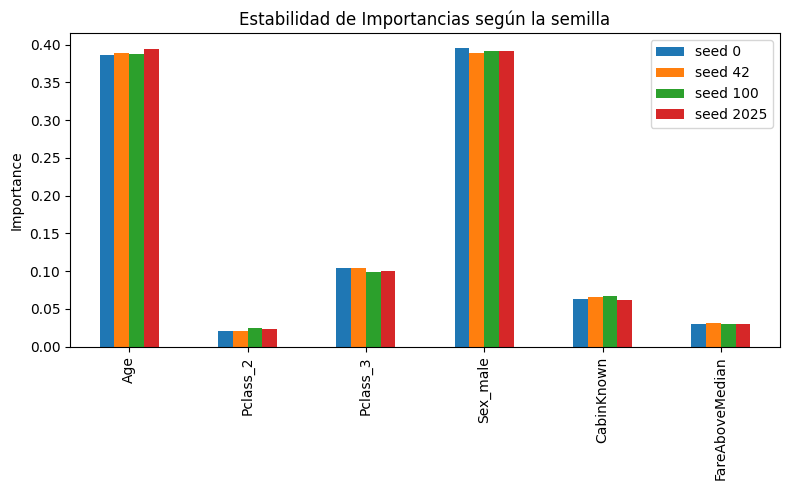

In [91]:
seeds = [0, 42, 100, 2025]
importancias = []

for seed in seeds:
    rf_temp = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=b_p[2],
        min_samples_leaf=b_p[3],
        max_features=b_p[4],
        random_state=seed,
        n_jobs=-1)
    rf_temp.fit(X_train, Y_train)
    importancias.append(rf_temp.feature_importances_)

df_importancias = pd.DataFrame(importancias, columns=X_train.columns, index=[f"seed {s}" for s in seeds])
print(df_importancias)

df_importancias.T.plot(kind="bar", figsize=(8,5))
plt.title("Estabilidad de Importancias según la semilla")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Evaulación y Comparación

In [92]:
# Predicciones
y_proba = model.predict_proba(X_test)[:, 1] 

# Métricas básicas
accuracy  = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall    = recall_score(Y_test, y_pred)
f1        = f1_score(Y_test, y_pred)

roc_auc   = roc_auc_score(Y_test, y_proba)
pr_auc    = average_precision_score(Y_test, y_proba)
mcc       = matthews_corrcoef(Y_test, y_pred)
bal_acc   = balanced_accuracy_score(Y_test, y_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print(f"PR-AUC:    {pr_auc:.3f}")
print(f"MCC:       {mcc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")

Accuracy:  0.844
Precision: 0.859
Recall:    0.743
F1-Score:  0.797
ROC-AUC:   0.865
PR-AUC:    0.822
MCC:       0.676
Balanced Accuracy: 0.829


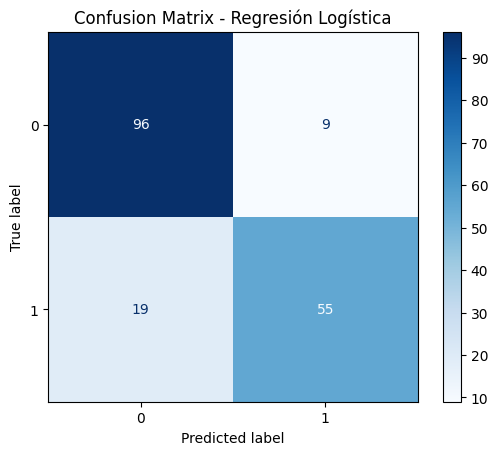

In [93]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Regresión Logística")
plt.show()

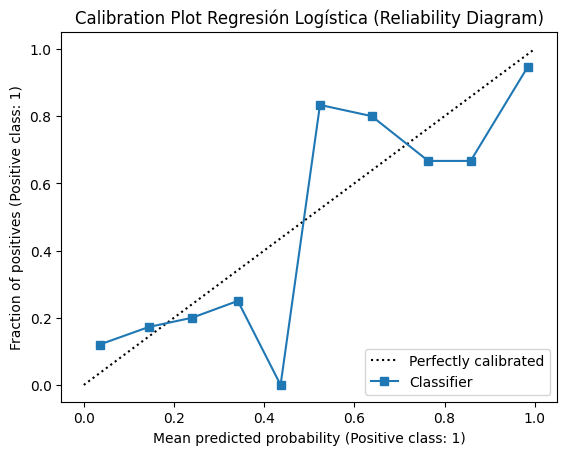

Brier Score: 0.13585201293856952
Expected Calibration Error (ECE): 0.07634573222199345


In [94]:
disp = CalibrationDisplay.from_predictions(
    Y_test, y_proba, n_bins=10, strategy="uniform")
plt.title("Calibration Plot Regresión Logística (Reliability Diagram)")
plt.show()

from sklearn.metrics import brier_score_loss

brier = brier_score_loss(Y_test, y_proba)
print("Brier Score:", brier)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            avg_conf = y_prob[mask].mean()
            avg_acc  = y_true[mask].mean()
            ece += np.abs(avg_conf - avg_acc) * len(y_prob[mask]) / len(y_prob)
    return ece

ece = expected_calibration_error(Y_test.values, y_proba, n_bins=10)
print("Expected Calibration Error (ECE):", ece)